<a href="https://colab.research.google.com/github/kmathapati/DS/blob/master/Ono_SLDR_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#List of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
%matplotlib inline

In [3]:
#Setting the working directory
os.chdir('C:/Users/q832369/OneDrive - IQVIA/Study/Ono/2019/Apr')

FileNotFoundError: ignored

In [ ]:
#Accessing the file
#QDR
slr = pd.read_csv('Trial_QA.csv',encoding = 'latin1',skip_blank_lines=True)

In [ ]:
slr.columns = slr.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
from io import StringIO

In [ ]:
slr.columns

Index(['site', 'subject', 'form', 'field', 'log..', 'query.status',
       'qry.open.date', 'qry.open.by', 'query.text', 'marking.gr..name',
       'qry.respon.date', 'site.response.text', 'qry.respnded.by', 'signal',
       'db_status'],
      dtype='object')

In [ ]:
col = ['db_status', 'site.response.text']

In [ ]:
slr = slr[col]

## We will remove missing values in “Site response text” column, and add a column encoding the "db status" as an integer because categorical variables are often better represented by integers than strings.

We also create a couple of dictionaries for future use.

After cleaning up, this is the first five rows of the data we will be working on:

In [ ]:
slr = slr[pd.notnull(slr['site.response.text'])]

In [ ]:
slr.columns = ['db_status', 'site.response.text']

In [ ]:
slr['category_id'] = slr['db_status'].factorize()[0]

In [ ]:
category_id_df = slr[['db_status', 'category_id']].drop_duplicates().sort_values('category_id')

In [ ]:
category_to_id = dict(category_id_df.values)

In [ ]:
sorted(category_to_id.items())

[('No', 1), ('Yes', 0)]

In [ ]:
id_to_category = dict(category_id_df[['category_id', 'db_status']].values)

In [ ]:
slr.head()

,db_status,site.response.text,category_id
0,Yes,Updated.,0
1,Yes,Updated.,0
2,Yes,updated,0
3,Yes,updated,0
4,Yes,updated,0


## Text Representation
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a site response text narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of site response text:

sublinear_df is set to True to use a logarithmic form for frequency.

min_df is the minimum numbers of documents a word must be present in to be kept.

norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.

ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [ ]:
slr['site.response.text'].head()

0    Updated.
1    Updated.
2     updated
3     updated
4     updated
Name: site.response.text, dtype: object

In [ ]:
features = tfidf.fit_transform(slr['site.response.text']).toarray()

In [ ]:
labels = slr.category_id

In [ ]:
features.shape

(1307, 217)

## Now, each of 971 site response texts are represented by 48 features, representing the tf-idf score for different unigrams and bigrams.

## Multi-Class Classifier: 
Features and Design
To train supervised classifiers, we first transformed the “site response text” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
After having this vector representations of the text we can train supervised classifiers to train unseen “site response text” and predict the “db status” on which they fall.
After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

The training set is a subset of the data set used to train a model.

x_train is the training data set.
y_train is the set of labels to all the data in x_train.
The test set is a subset of the data set that you use to test your model after the model has gone through initial vetting by the validation set.

x_test is the test data set.
y_test is the set of labels to all the data in x_test.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(slr['site.response.text'], slr['db_status'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
X_train, X_test, y_train, y_test

(759                                  2018.3.13 UV updated
 1010                                             Updated.
 82                                           data correct
 520                                                   NCS
 861                            original value is correct.
 996     The investigator determined the value as not c...
 1242                                              updated
 921                                        data was added
 252                          Dose delayed on Cycle5 Day1.
 416                                              Updated.
 311                                         updated data.
 1062                         eligibility pose no problems
 113                                              Updated.
 942                                               Updated
 249                              refer to medical history
 968                                              Updated.
 263                                                   N

## After fitting the training set, let’s make some predictions.

In [ ]:
#predicting new SLDR closed queries
print(clf.predict(count_vect.transform(["NCS"])))

['No']


Cross checking predicted query

In [ ]:
slr[slr['site.response.text'] == " "]

,db_status,site.response.text,category_id


## Model Selection
We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:

Logistic Regression

(Multinomial) Naive Bayes

Linear Support Vector Machine

Random Forest

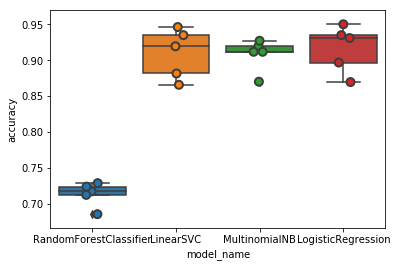

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.909719
LogisticRegression        0.916604
MultinomialNB             0.908207
RandomForestClassifier    0.713834
Name: accuracy, dtype: float64

Multinomial NB and Logistic Regression perform better than the other two classifiers, with both having a slight advantage with a median accuracy of around 94%.

## Model Evaluation
Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

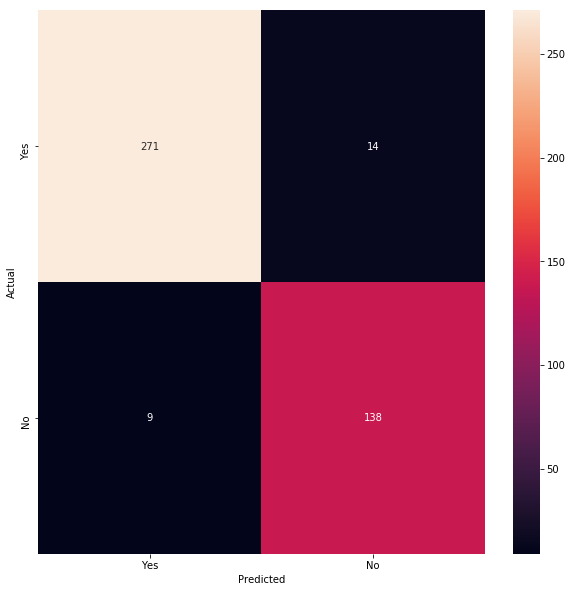

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, slr.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.db_status.values, yticklabels=category_id_df.db_status.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
lm = MultinomialNB()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.9328703703703703

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(slr.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['db_status', 'site.response.text']])
      print('')

'Yes' predicted as 'No' : 14 examples.


,db_status,site.response.text
870,Yes,12/25 AMY 175 IU/L
1164,Yes,done
1265,Yes,1
1076,Yes,updata
833,Yes,error
1091,Yes,done
1012,Yes,Concomitant medications started prior to the f...
269,Yes,OK
1088,Yes,chemotherapy was skipped due to this AE.
252,Yes,Dose delayed on Cycle5 Day1.


In [ ]:
model.fit(features, labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=slr['db_status'].unique()))

             precision    recall  f1-score   support

        Yes       0.97      0.95      0.96       285
         No       0.91      0.94      0.92       147

avg / total       0.95      0.95      0.95       432



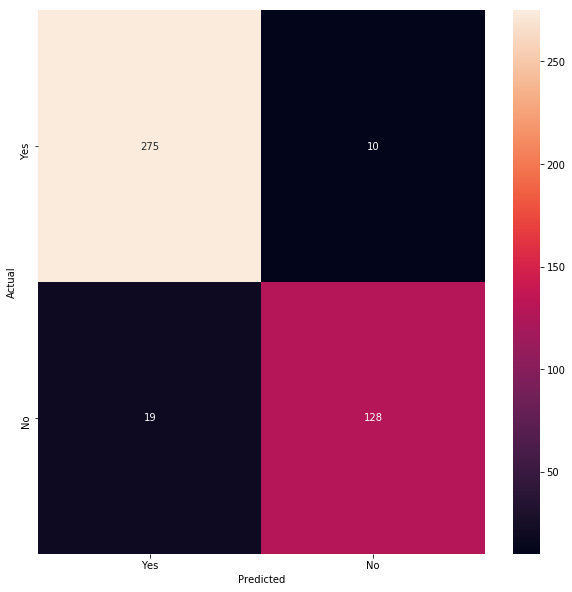

In [ ]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, slr.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.db_status.values, yticklabels=category_id_df.db_status.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(slr.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['db_status', 'site.response.text']])
      print('')

'No' predicted as 'Yes' : 19 examples.


,db_status,site.response.text
930,No,The start date was modified.
161,No,"here was no major complaint at this visit, so ..."
268,No,due to pnuemonia
85,No,The SAE report occured on 02Jul2018 as reference
935,No,we confirmed not meet
481,No,"Please see at the Lab data on March 29, 2018."
184,No,none
254,No,Not significant
926,No,unscheduled visit
247,No,Include to FN



'Yes' predicted as 'No' : 10 examples.


,db_status,site.response.text
1140,Yes,applicable AE Number Dose EXOT on concomitant...
1012,Yes,Concomitant medications started prior to the f...
580,Yes,Corresponding laboratory data is recorded.
1203,Yes,applicable AE Number Dose EXOT on concomitant...
1088,Yes,chemotherapy was skipped due to this AE.
252,Yes,Dose delayed on Cycle5 Day1.
1228,Yes,chemotherapy related nausea grade2~grade3
578,Yes,Corresponding laboratory data is recorded.
840,Yes,AE line 10 was updasted
1214,Yes,Investigational product was skipped at C2D1.
